<a href="https://colab.research.google.com/github/danielfoliveira4040/neural-network-stock-price/blob/main/Stock_Market_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**CARREGAMENTO E TRATAMENTO DOS DADOS:**

In [6]:
!pip3 install numpy
!pip3 install pandas
!pip3 install matplotlib
!pip3 install tensorflow
!pip3 install scikit-learn
!pip3 install keras

# Introdução

O trabalho neste notebook explora um algoritmo de Aprendizado de Máquina denominado Rede Neural Recorrente (RNN), uma técnica de Deep Learning comum usada para reconhecimento de padrão de dados contínuos. A Rede Neural Recorrente leva em consideração como os dados mudam ao longo do tempo e normalmente é usada para dados de série temporal (preços de ações, leituras de sensores, etc.)

Será feita uma tentativa de previsão do preço das ações de empresa Berkshire Hathaway utilizando seu histórico de preço desde o IPO na Nasdaq, uma das maiores bolsas de valores dos Estados Unidos.



# Objetivo

Foram utilizados dados do próprio mercado para realização do treino e das previsões. Os dados foram retirados especificamente da API do [Yahoo! Finance](https://finance.yahoo.com/quote/BRK-A/history). Os dados demandaram um nível muito básico de tratamento. Com algumas modificações via Excel já foi possível utilizá-los para o trabalho. Resumindo, não foi necessário nenhum tipo de tratamento via Pandas para utilização do dataset.

As informações que compoem o dataset são:


1.   Date: data do registro do pregão
2.   Open: preço de abertura da ação
3.   High: máxima de preço atingido no pregão
4.   Low: mínima de preço atingido no pregão
5.   Close: preço de fechamento do pregão
6.   Volume: volume de negociação

# Metodologia

![](https://iamtrask.github.io/img/backprop_through_time.gif)

Uma rede neural recorrente (RNN) é uma classe de redes neurais artificiais onde as conexões entre os nós formam um grafo digirido ao longo de uma série temporal. Isso permite que ele exiba um comportamento dinâmico temporal.

Como as redes neurais de feedforward e convolucionais (CNNs), as redes neurais recorrentes utilizam dados de treinamento para aprender. O RNN se distingue por sua “memória”, pois recebe informações de entradas anteriores para influenciar a entrada e a saída atuais. Enquanto as redes neurais de deep learning tradicionais presumem que as entradas e saídas são independentes umas das outras, a saída das redes neurais recorrentes depende dos elementos anteriores dentro da sequência (vide figura acima).

# O problema (RNN Gradiente)

O gradiente é usado para atualizar os pesos em um RNN, olhando para trás um certo número de etapas definidas pelo usuário. Quanto mais baixo o gradiente, mais difícil é atualizar os pesos (gradiente de dissipação) dos nós mais para trás no tempo. Especialmente porque as camadas anteriores são usadas como entradas para as camadas futuras. Isso significa que os neurônios antigos estão treinando muito mais devagar do que os neurônios atuais. É como um efeito dominó.

# Solução (LSTM)

A solução escolhida aqui foi o LSTM. O Long short-term memory (LSTM) é uma arquitetura de rede neural recorrente artificial (RNN) usada no campo do deep learning. Ao contrário das redes neurais feedforward padrão, o LSTM tem conexões de feedback. Ele pode processar não apenas pontos de dados únicos (como imagens), mas também sequências inteiras de dados (como fala ou vídeo). Por exemplo, o LSTM é aplicável a tarefas como reconhecimento de manuscrito, reconhecimento de voz e previsão para preço de ações, que é o nosso caso de estudo.

![](https://www.researchgate.net/profile/Olivier-Risser-Maroix/publication/325929737/figure/fig1/AS:640313823617025@1529674120535/Cellule-de-type-LSTM.png)

Uma unidade LSTM comum é composta de uma célula, uma porta de entrada, uma porta de saída e uma porta de esquecimento. A célula lembra valores em intervalos de tempo arbitrários e as três portas regulam o fluxo de informações para dentro e para fora da célula.

In [7]:
# Part 1 - Data Preprocessing
#Bibliotecas básicas do python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


dataset_train = pd.read_csv('https://gist.githubusercontent.com/danielfoliveira4040/0967e21eae841c98e9dfe85fe87233c7/raw/36024ec5a54b939469044eccaa22f9dadd386579/train.csv')
training_set = dataset_train.iloc[:, 1:2].values

#Bibliotecas para utilização do Sklearn
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
y_train = []
for i in range(60, len(dataset_train)-1):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

dataset_train

,Date,Open,High,Low,Close,Volume
0,5/9/1996,22.200001,24.400000,22.200001,23.200001,4290000
1,5/10/1996,24.000000,24.200001,23.600000,24.000000,1060000
2,5/13/1996,24.000000,24.100000,23.299999,23.900000,700000
3,5/14/1996,24.000000,24.100000,23.100000,23.600000,310000
4,5/15/1996,23.600000,23.700001,23.000000,23.200001,545000
...,...,...,...,...,...,...
5695,12/24/2018,190.699997,191.639999,187.110001,187.759995,5020600
5696,12/26/2018,188.649994,197.929993,186.100006,197.570007,7158200
5697,12/27/2018,195.600006,200.119995,191.899994,200.119995,7386800
5698,12/28/2018,200.720001,204.740005,200.199997,202.080002,5420600


In [8]:
# Part 2 - Building the RNN

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))


regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
 55/177 [========>.....................] - ETA: 14s - loss: 0.0118

KeyboardInterrupt: ignored

# Previsões

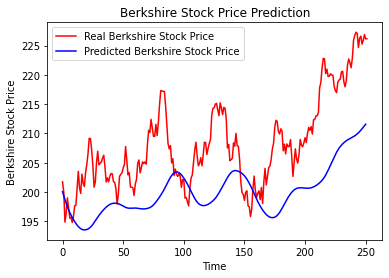

In [10]:
# Part 3 - Making the predictions and visualising the results

dataset_test = pd.read_csv('https://gist.githubusercontent.com/danielfoliveira4040/7424ec86d261e7562c96f67e2aba5f96/raw/876d69dc0d07f6cc4acf6a23de168fd1098df1d7/test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 60+len(dataset_test)-1):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


plt.plot(real_stock_price, color = 'red', label = 'Real Berkshire Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Berkshire Stock Price')
plt.title('Berkshire Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Berkshire Stock Price')
plt.legend()
plt.show()


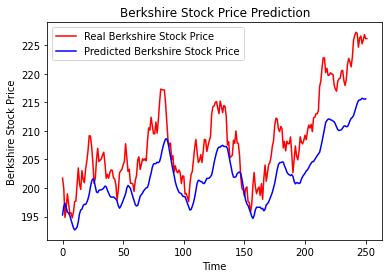

Os resultados acima foram atingidos a partir de um treinamento com os dados de 1996 a 2018 e um teste com o ano completo de 2019. Conseguimos resultados bastante atrativos, apesar de não utilizáveis na prática

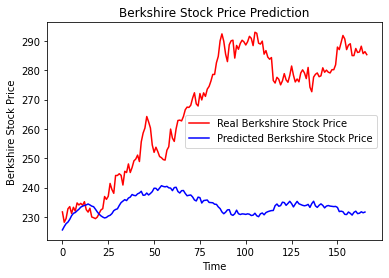

Entretanto, podemos ver que outros testes não se deram tão bem. O treino de 1996 a 2020 com testes em 2021 não obteve resultados satisfatórios. Podemos atribuir a acurácia baixa ao evento de pandemia que estamos vivendo desde 2020 que afetou fortemente o mercado financeiro, criando tendências fora do padrão. Como os dados utilizados no dataset se resumem exclusivamente ao preço da ação, a rede neural não tem conhecimento desse fato relevante.

# Conclusão

O trabalho foi desenvolvido com sucesso, obtendo-se um resultado interessante para uma primeira tentativa de previsão. Levando em consideração o número baixo e de alta correlação entre features, sabe-se que existem muitas possibilidades de otimização que certamente tenderiam a melhorar a performance da rede, obtendo-se assim resultados mais satisfatórios. Outro caminho possível de melhoria poderia ser a análise de outras ações dos mesmos setores ou com outro tipo de correlação, a fim de refinar ainda mais o modelo.

Os percalços encontrados no processo foram ferramentas de aprendizado que serão de grande utilidade para futuras demandas em outras disciplinas. A continuação da matéria foi devidamente aproveitada para conectar o conhecimento dos trabalhos anteriores e realizar algo ainda mais interessante neste último.